In [1]:
!pip install -U --no-cache-dir transformers accelerate medmnist scikit-learn matplotlib


In [2]:
import torch
from transformers import AutoImageProcessor, ViTMAEForPreTraining
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
mae_hf = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

# Dummy image 224×224
arr = (np.random.rand(224,224,3)*255).astype(np.uint8)
img = Image.fromarray(arr)

inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = mae_hf(**inputs)

print("HF ViT-MAE OK → loss:", float(outputs.loss))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

HF ViT-MAE OK → loss: 1.6332274675369263


In [3]:
# Step 1: Imports & Config

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import numpy as np, random, time, math
from pathlib import Path
from PIL import Image
from collections import Counter, defaultdict

# HF models
from transformers import (
    AutoImageProcessor, ViTMAEForPreTraining,
    DeiTImageProcessor, DeiTForImageClassification
)

# Metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Data
!pip -q install medmnist
from medmnist import DermaMNIST

# Repro & device
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --- Improved Configuration for longer training ---

class CFG:
    img_size = 224
    batch_size = 64
    mae_epochs = 10        # previously 2 → increased for better reconstruction learning
    clf_epochs = 20        # previously 3 → increased for stronger classifier convergence
    lr_mae = 1e-4
    lr_clf = 1e-4
    synth_root = Path("./synthetic_derma_hf")
    synth_per_image = 3    # more synthetic variants per real image

CFG.synth_root.mkdir(exist_ok=True, parents=True)
print("Updated epochs — MAE:", CFG.mae_epochs, "| DeiT:", CFG.clf_epochs)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.0 MB/s eta 0:00:00
Device: cuda
Updated epochs — MAE: 10 | DeiT: 20


In [4]:
# Step 2: Load DermaMNIST

train_raw = DermaMNIST(split='train', download=True)
val_raw   = DermaMNIST(split='val',   download=True)
test_raw  = DermaMNIST(split='test',  download=True)

def get_rgb_label(ds, i):
    x, y = ds[i]
    return x.convert("RGB"), int(y[0])

NUM_CLASSES = len(np.unique(train_raw.labels))
labels = [get_rgb_label(train_raw, i)[1] for i in range(len(train_raw))]
counts = Counter(labels)
max_count = max(counts.values())

print("Classes:", NUM_CLASSES)
print("Train counts:", dict(counts))


100%|██████████| 19.7M/19.7M [00:24<00:00, 810kB/s] 


Classes: 7
Train counts: {0: 228, 5: 4693, 4: 779, 2: 769, 1: 359, 6: 99, 3: 80}


In [5]:
# Step 3: MAE setup (Hugging Face)

mae_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

# Small dataset wrapper for MAE (uses MAE processor internally)
class DermaForMAE(Dataset):
    def __init__(self, base_ds, processor):
        self.ds = base_ds
        self.p = processor
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, y = get_rgb_label(self.ds, i)
        enc = self.p(images=img, return_tensors="pt")
        return {k: v.squeeze(0) for k,v in enc.items()}, y  # pixel_values key is present

train_mae_ds = DermaForMAE(train_raw, mae_processor)
train_mae_loader = DataLoader(train_mae_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2)

# (Optional) Light MAE fine-tuning
opt_mae = torch.optim.AdamW(mae_model.parameters(), lr=CFG.lr_mae)
for ep in range(1, CFG.mae_epochs+1):
    mae_model.train()
    total = 0.0
    for batch, _ in train_mae_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = mae_model(**batch)  # out.loss is MAE recon loss
        loss = out.lossttii  c nenihimesrs  wgwt 3h euthoi   rw
ni  nhpys
        opt_mae.zero_grad(set_to_none=True)
        loss.backward()
        opt_mae.step()
        total += loss.item() * batch['pixel_values'].size(0)
    print(f"[MAE] Epoch {ep}/{CFG.mae_epochs} | loss={total/len(train_mae_loader.dataset):.4f}")


preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

[MAE] Epoch 1/10 | loss=0.0060
[MAE] Epoch 2/10 | loss=0.0040
[MAE] Epoch 3/10 | loss=0.0040
[MAE] Epoch 4/10 | loss=0.0037
[MAE] Epoch 5/10 | loss=0.0037
[MAE] Epoch 6/10 | loss=0.0037
[MAE] Epoch 7/10 | loss=0.0036
[MAE] Epoch 8/10 | loss=0.0035
[MAE] Epoch 9/10 | loss=0.0037
[MAE] Epoch 10/10 | loss=0.0035


In [6]:
# === STEP 3: MAE setup (Hugging Face) ===
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, ViTMAEConfig, ViTMAEForPreTraining

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Fast processor + explicit mask ratio = 0.75
mae_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
cfg_mae = ViTMAEConfig.from_pretrained("facebook/vit-mae-base")
cfg_mae.mask_ratio = 0.75
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base", config=cfg_mae).to(device)

# Small dataset wrapper (expects get_rgb_label -> PIL RGB, int label)
class DermaForMAE(Dataset):
    def __init__(self, base_ds, processor):
        self.ds = base_ds
        self.p = processor
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, y = get_rgb_label(self.ds, i)        # img must be RGB
        enc = self.p(images=img, return_tensors="pt")
        return {k: v.squeeze(0) for k, v in enc.items()}, int(y)

train_mae_ds = DermaForMAE(train_raw, mae_processor)
train_mae_loader = DataLoader(train_mae_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2)

# 2) Optimizer + training loop (same as yours)
opt_mae = torch.optim.AdamW(mae_model.parameters(), lr=CFG.lr_mae, weight_decay=0.05)

for ep in range(1, CFG.mae_epochs + 1):
    mae_model.train()
    total = 0.0
    for batch, _ in train_mae_loader:
        batch = {k: v.to(device) for k, v in batch.items()}        # includes 'pixel_values'
        out = mae_model(**batch)                                    # self-supervised recon
        loss = out.loss                                             # MSE on masked patches
        opt_mae.zero_grad(set_to_none=True)
        loss.backward()
        opt_mae.step()
        total += loss.item() * batch["pixel_values"].size(0)
    print(f"[MAE] Epoch {ep}/{CFG.mae_epochs} | loss={total/len(train_mae_loader.dataset):.4f}")


[MAE] Epoch 1/10 | loss=0.0061
[MAE] Epoch 2/10 | loss=0.0041
[MAE] Epoch 3/10 | loss=0.0038
[MAE] Epoch 4/10 | loss=0.0038
[MAE] Epoch 5/10 | loss=0.0037
[MAE] Epoch 6/10 | loss=0.0038
[MAE] Epoch 7/10 | loss=0.0037
[MAE] Epoch 8/10 | loss=0.0036
[MAE] Epoch 9/10 | loss=0.0034
[MAE] Epoch 10/10 | loss=0.0036


In [7]:
import torch
from torchvision.utils import save_image
from pathlib import Path

# Use same masking as training
mae_model.config.mask_ratio = 0.75

IMG_SIZE, PATCH = 224, 16
h = w = IMG_SIZE // PATCH

def unpatchify(patches):
    B, N, D = patches.shape
    x = patches.reshape(B, h, w, PATCH, PATCH, 3).permute(0,5,1,3,2,4).contiguous()
    return x.view(B, 3, IMG_SIZE, IMG_SIZE)

def denorm_01(x):
    mean = torch.tensor(getattr(mae_processor,"image_mean",[0.5]*3), device=x.device).view(1,3,1,1)
    std  = torch.tensor(getattr(mae_processor,"image_std", [0.5]*3), device=x.device).view(1,3,1,1)
    return (x*std + mean).clamp(0,1)

@torch.no_grad()
def mae_reconstruct_images(imgs_pil, n_variants=1):
    out_imgs=[]
    for _ in range(n_variants):
        enc = mae_processor(images=imgs_pil, return_tensors="pt").to(device)  # pixel_values
        o = mae_model(**enc)                          # random masks each call
        logits = o.logits.clamp(0,1)                  # (B,N,3*16*16)
        mask   = o.mask.bool()                        # (B,N) True=masked

        B = enc["pixel_values"].size(0)
        def patchify(x):
            return x.view(B,3,h,PATCH,w,PATCH).permute(0,2,4,3,5,1).contiguous().view(B,h*w,3*PATCH*PATCH)

        pv_p = patchify(enc["pixel_values"])
        blended_p = pv_p.clone()
        blended_p[mask] = logits[mask]                # fill only masked tokens

        blended = unpatchify(blended_p)               # (B,3,224,224) normalized
        blended = denorm_01(blended)                  # [0,1] for saving/viewing
        for i in range(B): out_imgs.append(blended[i].cpu())
    return out_imgs


In [8]:
from PIL import Image

CFG.synth_root.mkdir(parents=True, exist_ok=True)
preview_dir = CFG.synth_root / "preview"; preview_dir.mkdir(parents=True, exist_ok=True)

def get_rgb_label(ds, i):
    x, y = ds[i]; return x.convert("RGB"), int(y[0])

idxs = [i for i in range(len(train_raw)) if get_rgb_label(train_raw,i)[1]==0][:16]
imgs = [get_rgb_label(train_raw,i)[0] for i in idxs[:8]]

recons = mae_reconstruct_images(imgs, n_variants=1)
for k, t in enumerate(recons[:4]):
    save_image(t, str(preview_dir / f"preview_{k}.png"))

print("Saved previews to:", preview_dir)


Saved previews to: synthetic_derma_hf/preview


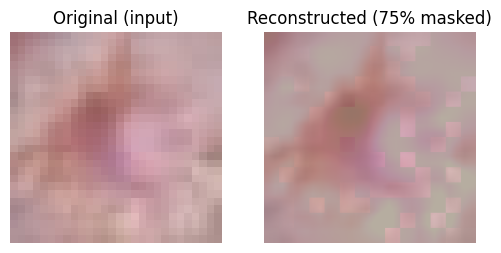

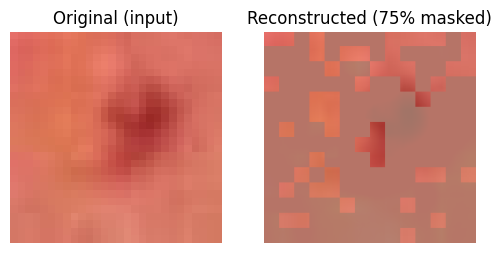

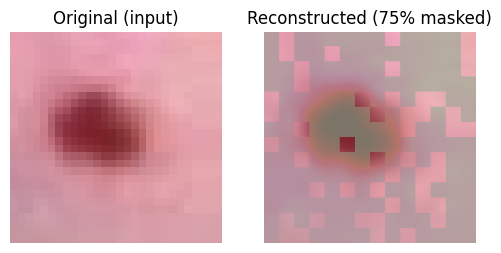

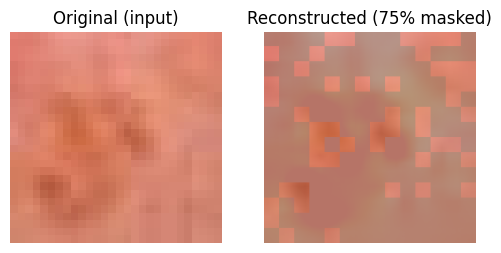

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

imgs = [get_rgb_label(train_raw, i)[0] for i in range(4)]  # 4 sample images

recons = mae_reconstruct_images(imgs, n_variants=1)

for i, (orig, recon) in enumerate(zip(imgs, recons)):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(orig)
    axs[0].set_title("Original (input)")
    axs[0].axis("off")
    axs[1].imshow(recon.permute(1,2,0))
    axs[1].set_title("Reconstructed (75% masked)")
    axs[1].axis("off")
    plt.show()


In [9]:
from collections import Counter
import time

# Build labels/counts (if not already)
try:
    labels, counts
except NameError:
    labels = [get_rgb_label(train_raw, i)[1] for i in range(len(train_raw))]
    counts = Counter(labels)

max_count = max(counts.values())

def pil_batch(ds, idxs, k=64):
    return [get_rgb_label(ds,i)[0] for i in idxs[:k]]

for c in sorted(set(labels)):
    have = len(list((CFG.synth_root/str(c)).glob("*.png")))
    need = max(0, max_count - counts[c] - have)
    if need == 0:
        print(f"Class {c}: up-to-date (need 0)"); continue

    print(f"Class {c}: need +{need} synthetic")
    idxs = [i for i,y in enumerate(labels) if y==c]
    saved = 0
    while saved < need:
        imgs = pil_batch(train_raw, idxs, k=64)
        recons = mae_reconstruct_images(imgs, n_variants=2)   # increase for more diversity if needed
        for rec in recons:
            if saved >= need: break
            p = CFG.synth_root/str(c)/f"{int(time.time()*1e6)}.png"
            p.parent.mkdir(parents=True, exist_ok=True)
            save_image(rec, str(p))
            saved += 1
        if saved % 500 == 0 or saved >= need:
            print(f"  saved {saved}/{need}")
    print(f"Class {c}: added {saved} synthetic")


Class 0: need +4465 synthetic
  saved 4465/4465
Class 0: added 4465 synthetic
Class 1: need +4334 synthetic
  saved 4334/4334
Class 1: added 4334 synthetic
Class 2: need +3924 synthetic
  saved 3924/3924
Class 2: added 3924 synthetic
Class 3: need +4613 synthetic
  saved 4613/4613
Class 3: added 4613 synthetic
Class 4: need +3914 synthetic
  saved 3914/3914
Class 4: added 3914 synthetic
Class 5: up-to-date (need 0)
Class 6: need +4594 synthetic
  saved 4594/4594
Class 6: added 4594 synthetic


In [10]:
from transformers import DeiTImageProcessor
from torch.utils.data import Dataset, DataLoader, ConcatDataset

deit_processor = DeiTImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")

class DermaForDeiT(Dataset):
    def __init__(self, base_ds, processor): self.ds, self.p = base_ds, processor
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, y = get_rgb_label(self.ds, i)
        x = self.p(images=img, return_tensors="pt")["pixel_values"].squeeze(0)  # (3,224,224)
        return x, y

class SynthFolder(Dataset):
    def __init__(self, root: Path, processor):
        self.samples=[]; self.p=processor
        root = Path(root)
        if root.exists():
            for d in sorted(root.iterdir()):
                if d.is_dir():
                    try: lab = int(d.name)
                    except: continue
                    for p in d.glob("*.png"): self.samples.append((p, lab))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        img = Image.open(p).convert("RGB")
        x = self.p(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return x, y

train_real  = DermaForDeiT(train_raw, deit_processor)
train_synth = SynthFolder(CFG.synth_root, deit_processor)

train_ds = ConcatDataset([train_real, train_synth])   # real + synthetic
val_ds   = DermaForDeiT(val_raw,   deit_processor)    # real-only
test_ds  = DermaForDeiT(test_raw,  deit_processor)    # real-only

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size, shuffle=False, num_workers=2)

print("Train:", len(train_ds), "| Val:", len(val_ds), "| Test:", len(test_ds))


Train: 32851 | Val: 1003 | Test: 2005


In [13]:
from transformers import ViTForImageClassification
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import f1_score, classification_report

# 1) Load classifier (use ViT here for the 'deit-tiny' weights)
clf_id = "facebook/deit-tiny-patch16-224"
model = ViTForImageClassification.from_pretrained(
    clf_id,
    num_labels=NUM_CLASSES,             # 7 classes in DermaMNIST
    ignore_mismatched_sizes=True        # lets HF adapt the head shape
).to(device)

# 2) Optimizer & loss
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_clf, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

# 3) Validation macro-F1 function
def eval_macro_f1(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(pixel_values=x).logits
            pred = logits.argmax(1).cpu().numpy()
            ys.append(np.array(y)); ps.append(pred)
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    return f1_score(y_true, y_pred, average='macro'), y_true, y_pred


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
best_f1 = -1.0
best_state = None
patience = 5
wait = 0

for ep in range(1, CFG.clf_epochs + 1):
    model.train()
    total = 0.0
    for x, y in train_loader:                 # train = real + synthetic
        x = x.to(device)
        y = torch.as_tensor(y, device=device)
        out = model(pixel_values=x)
        loss = criterion(out.logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total += loss.item() * x.size(0)

    val_f1, _, _ = eval_macro_f1(model, val_loader)   # val = real-only
    print(f"[ViT] Epoch {ep}/{CFG.clf_epochs} | train_loss={total/len(train_loader.dataset):.4f} | val_macroF1={val_f1:.4f}")

    # keep best model by val macro-F1
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {ep}")
            break


[ViT] Epoch 1/20 | train_loss=0.3741 | val_macroF1=0.4827
[ViT] Epoch 2/20 | train_loss=0.1472 | val_macroF1=0.5408
[ViT] Epoch 3/20 | train_loss=0.1396 | val_macroF1=0.5727
[ViT] Epoch 4/20 | train_loss=0.1232 | val_macroF1=0.5956
[ViT] Epoch 5/20 | train_loss=0.1068 | val_macroF1=0.6121
[ViT] Epoch 6/20 | train_loss=0.1008 | val_macroF1=0.6070
[ViT] Epoch 7/20 | train_loss=0.0807 | val_macroF1=0.5719
[ViT] Epoch 8/20 | train_loss=0.0690 | val_macroF1=0.5874
[ViT] Epoch 9/20 | train_loss=0.0709 | val_macroF1=0.5987
[ViT] Epoch 10/20 | train_loss=0.0555 | val_macroF1=0.5922
Early stopping at epoch 10


In [15]:
# Load best weights & test
if best_state is not None:
    model.load_state_dict(best_state)

test_f1, y_true, y_pred = eval_macro_f1(model, test_loader)
print("\n=== FINAL TEST (REAL-ONLY) ===")
print("Macro-F1:", round(test_f1, 4))

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, digits=4))

# (Optional) confusion matrix
import numpy as np
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
print("Confusion matrix:\n", cm)



=== FINAL TEST (REAL-ONLY) ===
Macro-F1: 0.5556
              precision    recall  f1-score   support

           0     0.4286    0.5455    0.4800        66
           1     0.6207    0.5243    0.5684       103
           2     0.5041    0.5591    0.5302       220
           3     0.5333    0.3478    0.4211        23
           4     0.8182    0.1614    0.2697       223
           5     0.8475    0.9493    0.8955      1341
           6     0.7241    0.7241    0.7241        29

    accuracy                         0.7736      2005
   macro avg     0.6395    0.5445    0.5556      2005
weighted avg     0.7758    0.7736    0.7474      2005

Confusion matrix:
 [[  36   10   10    0    1    9    0]
 [  16   54   16    3    0    8    6]
 [  14    9  123    1    3   70    0]
 [   3    2    1    8    0    9    0]
 [   5    7   44    3   36  127    1]
 [  10    4   49    0    4 1273    1]
 [   0    1    1    0    0    6   21]]
